In [1]:
from gbstim.gb import GBCode
from gbstim.device import Device
from gbstim.bposd import BPOSD
import sinter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
l = 6
m = 6
device = Device((2*m, 2*l))
code = GBCode(device, [(0, 2), (0, 1), (3, 0)], [(1, 0), (2, 0), (0, 3)], l, m)
print(f'[{code.n}, {code.k}, {code.d}]')

[72, 12, 6]


In [3]:
display(device)

z@0   |d1@0  |z@6   |d1@6  |z@12  |d1@12 |z@18  |d1@18 |z@24  |d1@24 |z@30  |d1@30 |
------------------------------------------------------------------------------------------------
d2@0  |x@0   |d2@6  |x@6   |d2@12 |x@12  |d2@18 |x@18  |d2@24 |x@24  |d2@30 |x@30  |
------------------------------------------------------------------------------------------------
z@1   |d1@1  |z@7   |d1@7  |z@13  |d1@13 |z@19  |d1@19 |z@25  |d1@25 |z@31  |d1@31 |
------------------------------------------------------------------------------------------------
d2@1  |x@1   |d2@7  |x@7   |d2@13 |x@13  |d2@19 |x@19  |d2@25 |x@25  |d2@31 |x@31  |
------------------------------------------------------------------------------------------------
z@2   |d1@2  |z@8   |d1@8  |z@14  |d1@14 |z@20  |d1@20 |z@26  |d1@26 |z@32  |d1@32 |
------------------------------------------------------------------------------------------------
d2@2  |x@2   |d2@8  |x@8   |d2@14 |x@14  |d2@20 |x@20  |d2@26 |x@26  |d2@32 |x@32  |
-----

In [5]:
'''
Apologies in advance as this is pretty tedious and unsatisfying to specify

Specifying stabilizer order. Each group of 4 indicates a stabilizer step: 0: no periodicity, 1: horizontal periodicity, 2: vertical periodicity, 3: horizontal&vertical periodicity
0-3 Z-B_poly-0
4-7 Z-B_poly-1
8-11 Z-B_poly-2
12-15 Z-A_poly-0
16-19 Z-A_poly-1
20-23 Z-A_poly-2
24-27 X-A_poly-0
28-31 X-A_poly-1
32-35 X-A_poly-2
36-39 X-B_poly-0
40-43 X-B_poly-1
44-47 X-B_poly-2

Example construction for [72,12,6] code.
'''
ms_perm  = [24, 28, 36, 32, 44, 40] # no periodic X stabilizer
ms_perm += [38, 30, 26, 41, 45, 33] # periodic X stabilizer
ms_perm += [12, 16, 0, 20, 8, 4] # no periodic Z stabilizer
ms_perm += [2, 18, 14, 5, 9, 21] # periodic Z stabilizer
# Append unused indices
for i in np.arange(0, 48):
    if i not in ms_perm:
        ms_perm.append(i)

In [6]:
circ = code.stim_circ(num_rounds=code.d, ms_perm=ms_perm)

In [7]:
code.stab_move_time

3398.494950708319

In [8]:
tasks = []
p_range = [1e-3, 2e-3, 3e-3, 4e-3, 5e-3]
for p in p_range:
    tasks.append(sinter.Task(circuit=code.stim_circ(p, p, p, dec_type='Z', num_rounds=code.d), 
                                 json_metadata={'p': p, 
                                                'Code': f'[{code.n}, {code.k}, {code.d}] Weight {6}'}))

In [9]:
samples = sinter.collect(
    num_workers=4,
    max_shots=1_000_000,
    max_errors=100,
    tasks=tasks,
    decoders=['bposd'],
    custom_decoders={'bposd': BPOSD(max_iter=10_000, bp_method="ms", osd_order=10, osd_method="osd_cs")}
)

In [10]:
err_rates = [0 for _ in p_range]
for sample in samples:
    p = sample.json_metadata['p']
    err_rates[p_range.index(p)] = 1 - (1 - (sample.errors / sample.shots))**(1/code.d)

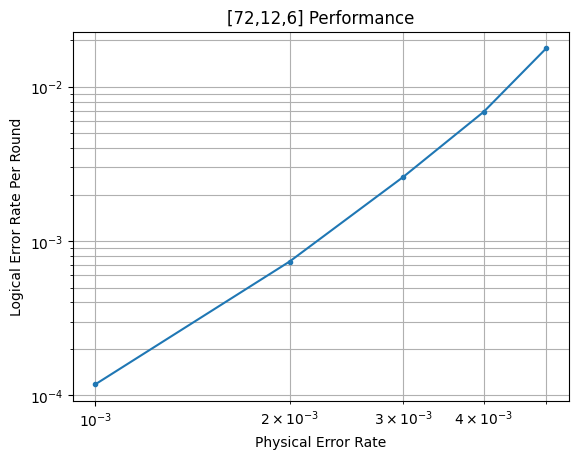

In [11]:
plt.plot(p_range, err_rates, marker='.')
plt.loglog()
plt.grid(which='both')
plt.title('[72,12,6] Performance')
plt.ylabel('Logical Error Rate Per Round')
plt.xlabel('Physical Error Rate')
plt.show()